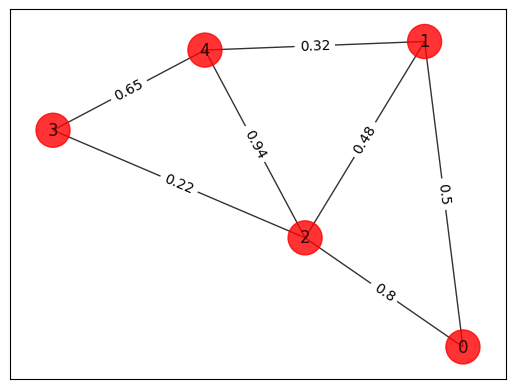

In [92]:
from collections import defaultdict
from typing import List, Tuple

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import matplotlib.pyplot as plt

import networkx as nx

import numpy as np

# Generating a graph of 4 nodes

n = 5  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

weights   = [0.5, 0.8, 0.32, 0.94, 0.22, 0.65, 0.48]
edge_list = [(0, 1, weights[0]),
             (0, 2, weights[1]),
             (1, 4, weights[2]),
             (2, 4, weights[3]),
             (2, 3, weights[4]),
             (3, 4, weights[5]),
             (1, 2, weights[6])]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edge_list)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


DISPLAY_GRAPH = True
if DISPLAY_GRAPH:
    draw_graph(G, colors, pos)
    plt.show()



In [93]:
def generate_Q(size: int, edges: List[Tuple[int, int, float]]) -> np.ndarray:
    """
    :param size: number of nodes in graph.
    :param edges: list of edges w. corresponding weight.
    :return: connectivity matrix of QUBO model, i.e. Q in x^TQx.
    """
    _Q = np.zeros(shape=(size, size), dtype=float)
    for _i, _j, _w in edges:
        _Q[_i, _j] += 2*_w
        _Q[_i, _i] -= 1*_w
        _Q[_j, _j] -= 1*_w
    return _Q

In [94]:
# ------- Set up our QUBO dictionary -------
# Get matrix from graph
init_Q = generate_Q(size=n, edges=edge_list)

# Initialize our Q matrix
Q = defaultdict(int)

# Update Q dictionary
for i in range(init_Q.shape[0]):
    for j in range(init_Q.shape[1]):
        Q[(i,j)]+= init_Q[i,j]

# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
chainstrength = 80
numruns = 10

# Run the QUBO on the solver from your config file
sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_qubo(Q,
                               chain_strength=chainstrength,
                               num_reads=numruns,
                               label='Example - Maximum Cut')

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
         [2, 3]      [0, 1, 4]     -2.87            2       
         [2, 4]      [0, 1, 3]     -2.47            2       
         [0, 3]      [1, 2, 4]-2.170000000000001       2       
      [1, 2, 4]         [0, 3]     -2.17            2       
      [1, 3, 4]         [0, 2]     -2.14            2       
         [0, 2]      [1, 3, 4]-2.1399999999999997       2       
            [4]   [0, 1, 2, 3]-1.9100000000000001       4       
      [0, 1, 2]         [3, 4]-1.4800000000000002       2       
   [0, 1, 2, 4]            [3]     -0.87            4       


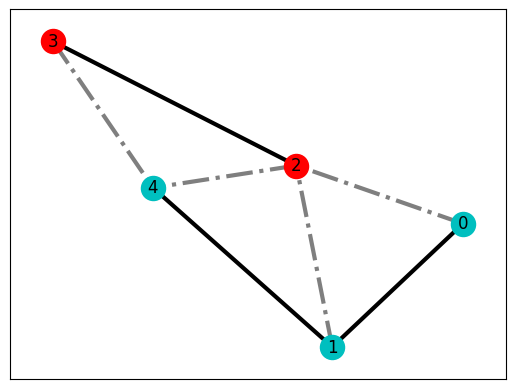

In [95]:
# ------- Print results to user -------
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for sample, E in response.data(fields=['sample','energy']):
    S0 = [k for k,v in sample.items() if v == 0]
    S1 = [k for k,v in sample.items() if v == 1]
    #print(sample.items())
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(abs(len(S0)-len(S1))+1)))

# ------- Display results to user -------
# Grab best result
# Note: "best" result is the result with the lowest energy
# Note2: the look up table (lut) is a dictionary, where the key is the node index
#   and the value is the set label. For example, lut[5] = 1, indicates that
#   node 5 is in set 1 (S1).
lut = response.first.sample

# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if not lut[node]]
S1 = [node for node in G.nodes if lut[node]]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)
plt.show()